# Exercise 03: CLIP zero-shot prediction
In this exercise, you will perform zero-shot prediction using CLIP.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision import transforms
import torchvision

from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from PIL import Image
from clip import clip

from torchvision.datasets import MNIST
from transformers import CLIPModel, CLIPProcessor

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Hyperparameters

In [2]:
# # random seed
# SEED = 1 
# NUM_CLASS = 10

# Training
BATCH_SIZE = 128
# NUM_EPOCHS = 30
# EVAL_INTERVAL=1
# SAVE_DIR = './log'

# # Optimizer
# LEARNING_RATE = 1e-1
# MOMENTUM = 0.9
# STEP=5
# GAMMA=0.5

# CLIP中图像处理的部分，用于捕捉图像的语义信息
VISUAL_BACKBONE = 'RN50' # RN50, ViT-B/32, ViT-B/16


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


1.CIFAR-10

In [11]:
#Normalization:
transform_cifar10_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_set = torchvision.datasets.CIFAR10(root='/shareddata', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dataset_name = 'CIFAR10'

Files already downloaded and verified


2.CIFAR-100

In [14]:
# CIFAR-100
transform_cifar100_test = transforms.Compose([
    transforms.Resize(size=224),
    transforms.CenterCrop(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

test_set_cifar100 = torchvision.datasets.CIFAR100(root='/shareddata', train=False,
                                                  download=True, transform=transform_cifar100_test)

test_dataloader_cifar100 = torch.utils.data.DataLoader(test_set_cifar100, batch_size=BATCH_SIZE,
                                                       shuffle=False, num_workers=2)

# CIFAR-100 类别名称
class_names_cifar100 = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# 数据集名称
dataset_name_cifar100 = 'CIFAR100'

Files already downloaded and verified


3.MNIST:

In [4]:
# 定义 MNIST 的测试集转换
transform_mnist_test = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # 调整大小以适应模型输入大小
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST 的均值和标准差
])

# 加载 MNIST 测试集
test_set_mnist = torchvision.datasets.MNIST(root='/shareddata', train=False,
                                            download=True, transform=transform_mnist_test)

# 创建 MNIST 测试集数据加载器
test_dataloader_mnist = torch.utils.data.DataLoader(test_set_mnist, batch_size=64,
                                                    shuffle=False, num_workers=2)

# MNIST 类别名称
class_names_mnist = [str(i) for i in range(10)]  # 数字 0-9

# 数据集名称
dataset_name_mnist = 'MNIST'

### Model

In [5]:
# Load the model, 这里无需随着数据集、backbone更改
model, preprocess = clip.load(name=VISUAL_BACKBONE, device=device, download_root='/shareddata/clip/')
model.to(device)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

### Task 1: Prompt Gereration
---

Please denfine a function named ``prompt_encode`` to encode the text using CLIP text encoder.


In [16]:
prompt = "a photo of a"

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names]).to(device)

In [16]:
# For dataset CIFAR-100
prompt = "a photo of a"

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names_cifar100]).to(device)

In [6]:
# For dataset MNIST:
prompt = "a photo of a"

text_inputs = torch.cat([clip.tokenize(f"{prompt} {c}") for c in class_names_mnist]).to(device)

### Task 2: Zero-shot inference
---

Please denfine a function named ``model_inference``. The function is essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Encode the image.
2. Encode the text.
3. Calculate the logits.

In [7]:
def model_inference(model, image):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    #encode
    image_features = model.encode_image(image)
    text_features = model.encode_text(text_inputs)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    logit_scale = model.logit_scale.exp()

    logits = logit_scale * image_features @ text_features.t()

    ###############################################################

    return logits

### Step 3: Zero-shot accuracy calculation
---

For CIFAR-10:

In [21]:
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set)



    print(f"the zero-shot performance on CIFAR-10 is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on CIFAR10 is 0.32%, visual encoder is ViT-B/32.


For CIFAR-100:

In [18]:
testing_loss = []
testing_acc = []

with torch.no_grad():
    model.eval()

    val_loss = 0.0
    val_corrects = 0

    for batch_idx, (image, target) in enumerate(test_dataloader_cifar100):

        image = image.to(device)
        target = target.to(device)

        # test model
        logits = model_inference(model, image)
        _, preds = torch.max(logits, 1)
        
        val_corrects += torch.sum(preds == target.data)

    val_acc = val_corrects.double() / len(test_set_cifar100)



    print(f"the zero-shot performance on CIFAR-100 is {val_acc*100:.2f}%, visual encoder is {VISUAL_BACKBONE}.")

the zero-shot performance on CIFAR-100 is 64.57%, visual encoder is ViT-B/16.


In [19]:
#acc_RN50_CIFAR10 = val_acc
# = 55.84%

In [ ]:
#acc_RN50_CIFAR100 = val_acc
# = 37.38%

In [31]:
#acc_V32 = val_acc
# = 85.47%

In [23]:
#acc_V32_CIFAR100 = val_acc
# = 60.19%

In [ ]:
#acc_V16 = val_acc
# = 88.03%

In [ ]:
# acc_V16_CIFAR100 = val_acc
# = 64.57%

### baseline model：ConvNet

In [10]:
from torchvision.datasets import CIFAR100
# 定义卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self, num_classes=100):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义一些常量
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

# 定义数据变换
transform_cifar100 = transforms.Compose([
    transforms.ToTensor(),
])

# 加载 CIFAR-100 数据集
train_set_cifar100 = CIFAR100(root='./data', train=True, download=True, transform=transform_cifar100)
test_set_cifar100 = CIFAR100(root='./data', train=False, download=True, transform=transform_cifar100)

# 创建数据加载器
train_dataloader_cifar100 = DataLoader(train_set_cifar100, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader_cifar100 = DataLoader(test_set_cifar100, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 初始化模型、损失函数和优化器
conv_net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=LEARNING_RATE)

# 训练模型
for epoch in range(EPOCHS):
    conv_net.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader_cifar100:
        optimizer.zero_grad()
        outputs = conv_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {running_loss / len(train_dataloader_cifar100)}")

# 评估模型
conv_net.eval()
correct_predictions = 0

with torch.no_grad():
    for inputs, labels in test_dataloader_cifar100:
        outputs = conv_net(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / len(test_set_cifar100)
print(f"Accuracy on CIFAR-100: {accuracy * 100:.2f}%")

100%|██████████| 169001437/169001437 [00:16<00:00, 9954765.51it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/10, Loss: 3.7106493312074704
Epoch 2/10, Loss: 2.874829454495169
Epoch 3/10, Loss: 2.4781670860012475
Epoch 4/10, Loss: 2.200415642517607
Epoch 5/10, Loss: 1.9596549267963985
Epoch 6/10, Loss: 1.736281222089782
Epoch 7/10, Loss: 1.5216156526294815
Epoch 8/10, Loss: 1.318036829495369
Epoch 9/10, Loss: 1.1283245010449148
Epoch 10/10, Loss: 0.9518998105965002
Accuracy on CIFAR-100: 39.65%


In [15]:
from torchvision.datasets import CIFAR10

# 定义卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义一些常量
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10

# 定义数据变换
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
])

# 加载 CIFAR-10 数据集
train_set_cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
test_set_cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

# 创建数据加载器
train_dataloader_cifar10 = DataLoader(train_set_cifar10, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_dataloader_cifar10 = DataLoader(test_set_cifar10, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 初始化模型、损失函数和优化器
conv_net = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=LEARNING_RATE)

# 训练模型
for epoch in range(EPOCHS):
    conv_net.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader_cifar10:
        optimizer.zero_grad()
        outputs = conv_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {running_loss / len(train_dataloader_cifar10)}")

# 评估模型
conv_net.eval()
correct_predictions = 0

with torch.no_grad():
    for inputs, labels in test_dataloader_cifar10:
        outputs = conv_net(inputs)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

accuracy = correct_predictions / len(test_set_cifar10)
print(f"Accuracy on CIFAR-10: {accuracy * 100:.2f}%")

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/10, Loss: 1.432616794353251
Epoch 2/10, Loss: 0.9771927068071902
Epoch 3/10, Loss: 0.7858092014289573
Epoch 4/10, Loss: 0.6463945827749379
Epoch 5/10, Loss: 0.5252492947651602
Epoch 6/10, Loss: 0.40933027711060954
Epoch 7/10, Loss: 0.30374238972583084
Epoch 8/10, Loss: 0.22184552601002672
Epoch 9/10, Loss: 0.16318300368307193
Epoch 10/10, Loss: 0.12865577705080627
Accuracy on CIFAR-10: 74.74%


In [21]:
import pandas as pd

c10_accuracy = [74.74, 55.84, 85.47, 88.03]
c100_accuracy = [39.65, 37.38, 60.19, 64.57]

data = {
    'Model': ['ConvNet', 'CLIP RN50', 'CLIP ViT-B/32', 'CLIP ViT-B/16'],
    'cifar-10': [f'{acc:.2f}%' for acc in c10_accuracy],
    'cifar-100': [f'{acc:.2f}%' for acc in c100_accuracy]
}

df = pd.DataFrame(data)

print("The accuracy of different models on different datasets is as below:")
print(df)

The accuracy of different models on different datasets is as below:
           Model cifar-10 cifar-100
0        ConvNet   74.74%    39.65%
1      CLIP RN50   55.84%    37.38%
2  CLIP ViT-B/32   85.47%    60.19%
3  CLIP ViT-B/16   88.03%    64.57%


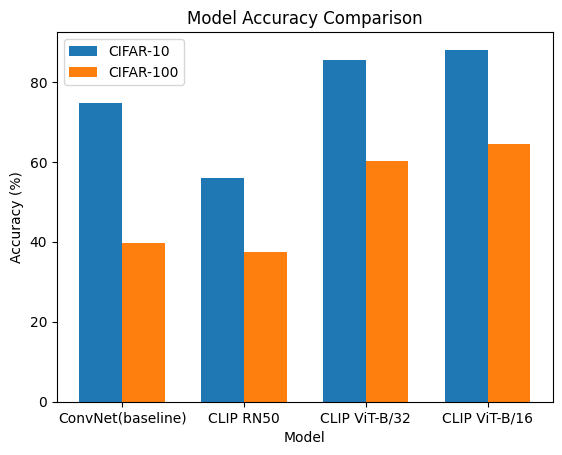

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 模型名称
models = ['ConvNet(baseline)', 'CLIP RN50', 'CLIP ViT-B/32', 'CLIP ViT-B/16']

# 准确率数据
c10_accuracy = np.array([74.74, 55.84, 85.47, 88.03])
c100_accuracy = np.array([39.65, 37.38, 60.19, 64.57])

# 创建图表
fig, ax = plt.subplots()

# 设置柱状图的宽度
bar_width = 0.35

# 绘制柱状图
bar_c10 = ax.bar(np.arange(len(models)), c10_accuracy, width=bar_width, label='CIFAR-10')
bar_c100 = ax.bar(np.arange(len(models)) + bar_width, c100_accuracy, width=bar_width, label='CIFAR-100')

# 添加标签、标题等
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Model Accuracy Comparison')
ax.set_xticks(np.arange(len(models)) + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

# 显示柱状图
plt.show()

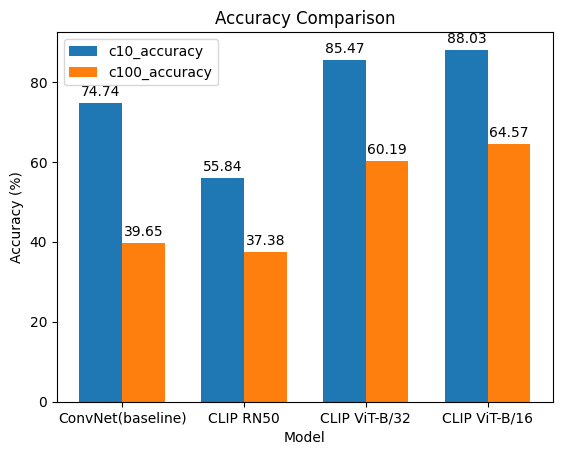

In [30]:
import matplotlib.pyplot as plt

# 假设有两个柱状图，分别表示 c10_accuracy 和 c100_accuracy
models = ['ConvNet(baseline)', 'CLIP RN50', 'CLIP ViT-B/32', 'CLIP ViT-B/16']
c10_accuracy = [74.74, 55.84, 85.47, 88.03]
c100_accuracy = [39.65, 37.38, 60.19, 64.57]

# 绘制柱状图
bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots()
bar1 = ax.bar(index, c10_accuracy, bar_width, label='c10_accuracy')
bar2 = ax.bar([i + bar_width for i in index], c100_accuracy, bar_width, label='c100_accuracy')

# 在每个柱状图上方标注数值
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bar1)
autolabel(bar2)

# 设置图表标题、轴标签等
ax.set_title('Accuracy Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(models)
ax.legend()

# 显示图表
plt.show()